In [1]:
library(benchmarkme)
get_platform_info()$OS.type
get_r_version()$version.string
get_cpu()$model_name;get_cpu()$no_of_cores
get_ram()

[1] "windows"

[1] "R version 3.5.1 (2018-07-02)"

[1] "Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz"

[1] 8

8.59 GB

In [2]:
##Package was modified to allow complete cross mating
#library("devtools")
#install_github("gglinzijie/xbreed")
library("xbreed")

("|-----------------------------------------------------|")
("|                      xbreed                         |")
("|    Genomic simulation of purebreds and crossbreds   |")
("|               March 2017 Version 1.0.1              |")
("|                                                     |")
("|             H.Esfandyari,A.C.Sorensen               |")
("| Center for Quantitative Qenetics and Genomics (QGG) |")
("|             Aarhus University,Denmark               |")
("|                                                     |")
("|-----------------------------------------------------|")
("|Questions and bugs: esfandyari.hadi@gmail.com        |")
("|Development of xbreed was supported by GenSAP.       |")
("|-----------------------------------------------------|")


# Genome specification

In [3]:
#Number of markers per chr from chapter 1
lin_map<-read.table("raw.map")
m=1:22
for(i in 1:22) {m[i]=dim(lin_map[lin_map$V1==i,])[1]}
sum(m)

[1] 3928

In [4]:
#data from chaptre 1
geno<-read.table("Hetero_realigned_cov10_filtered3.raw")
pheno<-read.csv("2017heteroPheno.csv", header=T)
attach(pheno)

In [7]:
#parameter of genome
no.chr<-22
genome<-data.frame(matrix(NA, nrow=no.chr, ncol=6))
names(genome)<-c("chr","len","nmrk","mpos","nqtl","qpos")
genome$chr<-c(1:no.chr) #Chromosome id from 1 to 22
genome$len<-c(200,rep(100,21))#Chromosome length in cM
genome$nmrk<-c(3*m) #Number of markers, 3*3928 in total 
genome$mpos<-c('even') 
genome$nqtl<-c(40) #Number of qtl  40*22 = 880 in total
genome$qpos<-c('rnd')

# Historiacal population

In [8]:
#Historical population 
hp<-make_hp(hpsize=1000 ,ng=1000,h2=0.654,d2=0,phen_var=84,
            genome=genome,mutr=2.5*10**-4,laf=1)

---sel_seq_qtl is missing, it has been set to default value of 0
---sel_seq_mrk is missing, it has been set to default value of 0
Historical pop is initialized...
Simulating trait ...
Output data preparation ...
Establishment of historical population completed


In [9]:
#validation
mutr<-2.5*10**-4
ne<-1000
k<-2 
Fneu<-4*ne*mutr
(Expected_het1<-1-((1+((Fneu)/(k-1)))/(1+((Fneu*k)/(k-1)))))
(het_observed<-mean(2*(hp$freqMrk[,3]*hp$freqMrk[,4])))

[1] 0.3333333

[1] 0.2819562

In [10]:
Male_founders<-data.frame(number=10,select='rnd')
Female_founders<-data.frame(number=10,select='rnd')

In [11]:
Selection<-data.frame(matrix(NA, nrow=2, ncol=3))
names(Selection)<-c('Number','type','Value') 
Selection$Number[1:2]<-c(10,10)
Selection$type[1:2]<-c('rnd','rnd')
Selection$Value[1:2]<-c('l','l')

In [12]:
sh_output<-data.frame(matrix(NA, nrow=1, ncol=4))
names(sh_output)<-c("data","qtl","freq_mrk","marker")
sh_output[1]<-c(1) 
sh_output[2]<-c(1) 
sh_output[3]<-c(1)
sh_output[4]<-c(1)

In [13]:
#10 sires and 10 dams perform complete cross; 200 eggs were produced per dam.
RP<-sample_hp(hp_out=hp,Male_founders= Male_founders,
              Female_founders=Female_founders,ng=1,Selection=Selection, 
              litter_size=100,saveAt="SNP3928",sh_output=sh_output,Display=FALSE)

Controlling input data ...
Intializing base population ...
Generation 0 started ......... 
Generation 0 is finished. Time taken: 12.84763
Generation 1 started ......... 
Generation 1 is finished. Time taken: 17.4952
Output data preparation ...
Writing output files ...
Sampling hp is done!


In [14]:
#function for calculate the allele coding, which is 0, 1, 2
bin_snp<-function(mat){
s1<-seq(1,ncol(mat),2)
s2<-seq(2,ncol(mat),2)
a1<-mat[,s1]+mat[,s2]
a1[a1==3]=1
a1[a1==4]=0
snp_code<-a1
return(snp_code)
 }

In [21]:
##geno and pheno from simulated data
pheno<-RP$output[[2]]$data$phen
n<-bin_snp(RP$output[[2]]$mrk[,3:23570])
x<-as.matrix(n)-1
data <- data.frame(tbcw=pheno,gid=1:1000)

In [23]:
##load packages
library(doParallel)
library(foreach)
cl<-makeCluster(8) 
repeats <- 10
n.fold <- 5 
acc<-list()
library(rrBLUP)
packageVersion("rrBLUP") 

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


[1] '4.6'

In [24]:
# Function for calculating the accuracy of GP with 
# varying size of reference population and varying denstiy of SNP panel
cal_acc<-function(x,n.sample,n.snp){
id<-sample(1:dim(x)[1],n.sample)
snpId<-sample(1:dim(x)[2],n.snp)
#relationship matrix (Endelman at al. 2011)
A <- A.mat(x[id,snpId], n.core=8)
row.names(A)=1:n.sample;colnames(A)=1:n.sample
data <- data.frame(tbcw=pheno[id],gid=1:n.sample)
registerDoParallel(cl)
GBLUP<-foreach(j=1:repeats,.combine = "rbind") %do% {
        set.seed(100+3*j+1)
        id <- sample(1:n.sample %% n.fold) + 1 
        foreach(i=1:n.fold,.packages="rrBLUP") %do% {
         bcw_test <- data
         bcw_test$tbcw[id == i] <- NA
         res <- kin.blup(bcw_test, K=A, geno="gid", pheno="tbcw")
         cor(data$tbcw[id==i],res$pred[id==i])
    }
   }
stopImplicitCluster()
acc<-unlist(GBLUP)
return(acc)
}

In [74]:
sum_m<-sum(m)
n.snp<-rep(c(round(0.1*sum_m),round(0.2*sum_m), 
             round(0.3*sum_m),round(0.4*sum_m),
             round(0.5*sum_m),round(0.6*sum_m),
             round(0.7*sum_m),round(0.8*sum_m),
             round(0.9*sum_m),sum_m,
             2*sum_m, 3*sum_m),each=2)
             
n.sample<-rep(c(500,1000),12)
pair<-data.frame(n.snp=n.snp,n.sample=n.sample)

In [75]:
#implemente the caculation 
all_acc<-matrix(NA,nrow = length(n.sample),ncol = repeats*n.fold)
for (i in 1:length(n.sample)){
    all_acc[i,]<-cal_acc(x,n.sample[i],n.snp[i])}

In [104]:
#Boxplot
library(ggplot2)
options(repr.plot.width=8, repr.plot.height=4)
plot<-data.frame(correlation=as.vector(t(all_acc)),
                 no_of_sample=as.factor(rep(n.sample,each = n.fold*repeats)),
                 n.snp=as.factor(rep(n.snp,each = n.fold*repeats)))
p <- ggplot(plot, aes(x=n.snp, y=correlation,fill=no_of_sample)) + 
     geom_boxplot()+
     scale_fill_manual(values=c("white", "skyblue"),
                       name="Size of \n reference\n population")+
     labs(x = "Density of SNP panel",y="Accuracy of GP")+
     theme(axis.text.y= element_text(size = rel(1.2)),
           axis.text.x = element_text(size = rel(1.2)),
           text=element_text(size=10, family="serif"))

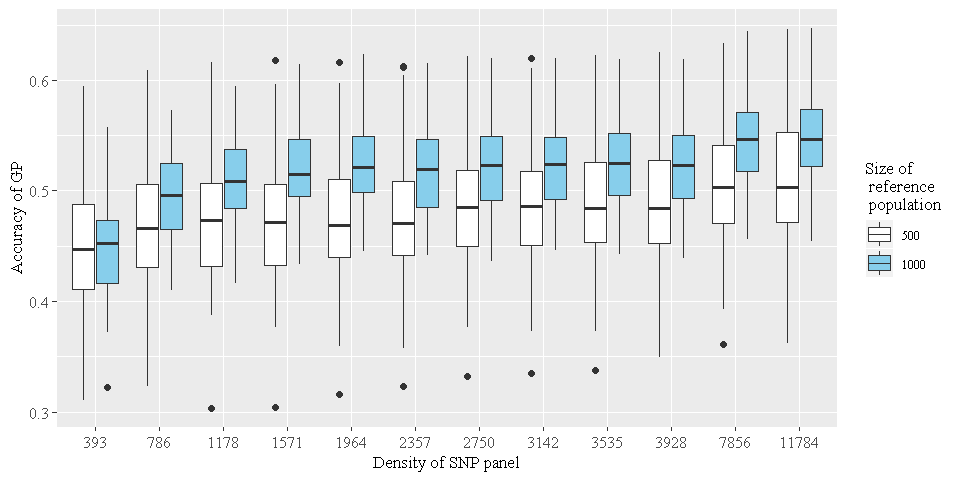

In [105]:
p

In [106]:
png("2.2 Density of SNP panel.png", width=8, height=4, units="in", res=300)
p
dev.off()

png 
  2

In [125]:
#caculate the mean and se of accuracy of GP
cal_se<-function(acc){sd(acc)/sqrt(repeats-1)}
(sum<-data.frame(n.snp=n.snp,
                 no_of_sample=n.sample,
                 acc_mean = apply(all_acc, 1, function(x) round(mean(x),3)),
                 acc_se = apply(all_acc, 1, function(x) round(cal_se(x),3))))

n.snp,no_of_sample,acc_mean,acc_se
393,500,0.447,0.021
393,1000,0.447,0.015
786,500,0.468,0.020
786,1000,0.494,0.013
1178,500,0.473,0.021
1178,1000,0.510,0.014
1571,500,0.471,0.020
1571,1000,0.518,0.013
1964,500,0.471,0.020
1964,1000,0.521,0.013


In [126]:
#save to xlsx file
library("xlsx")
write.xlsx(sum, "2_2.xlsx") 